In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Select Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# CIFAR-10 data
mean = (0.4914, 0.4822, 0.4465)
std = (0.247, 0.243, 0.261)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std) 
])

In [5]:
# Create Train and Test Loaders
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Create Dictionary for CIFAR-10 data
cifar_10_labels = {0: 'airplane',1: 'automobile',2: 'bird',3: 'cat', 4: 'deer', 
    5: 'dog', 6: 'frog', 7: 'horse',8: 'ship', 9: 'truck'}

In [7]:
# Use Resnet 18 
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

In [8]:
# Train Model
model.to(device)
for epoch in range(1, 10):
    model.train()  # Set the model to training mode
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        batch_loss = criterion(out, y_batch)
        batch_loss.backward()
        optimizer.step()

In [9]:
# Evaluate Model
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    out = model(x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += x_batch.size()[0]
    
print(f"Accuracy: {tot_acc/tot_test}")

Accuracy: 0.7105


### Integrated Gradients on Self-Trained ResNet (no Adversarial)

In [10]:
# Define Integrated Gradients 
ig = IntegratedGradients(model)

# Select Image to Demonstrate Saliency Map for
sample_idx = 10
sample_img = test_loader.dataset[sample_idx][0]
sample_img_label = test_loader.dataset[sample_idx][1]

unnormalize = transforms.Normalize((-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]),
                                   (1.0 / std[0], 1.0 / std[1], 1.0 / std[2]))
unnormalized_img = unnormalize(sample_img)

# Calculate attributions using Integrated Gradients
attributions = ig.attribute(sample_img.to(device).unsqueeze(0), target=sample_img_label, n_steps = 200)

label is 0 (airplane)


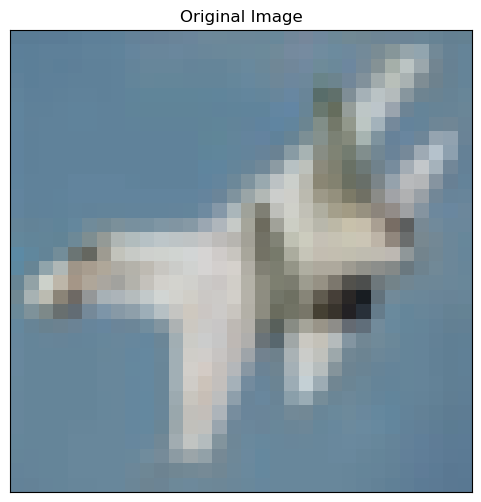

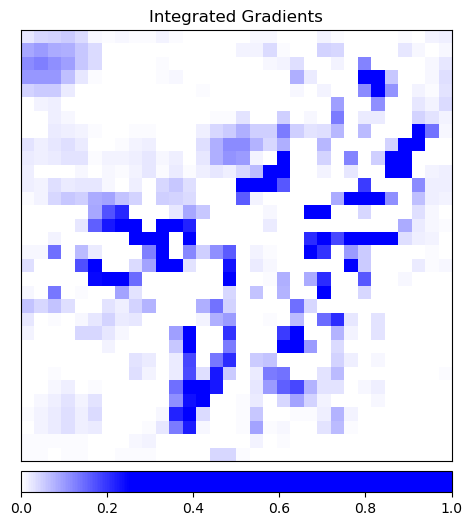

In [11]:
# Visualize Saliency Map and Compare to Original Image
print(f"label is {sample_img_label} ({cifar_10_labels[sample_img_label]})")
_ = viz.visualize_image_attr(None, np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)
_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

### Adversarial Training with PGD 

In [12]:
# Define PGD Attack
def pgd_attack(model, x, labels, eps, alpha, iters):
    x = x.to(device)
    labels = labels.to(device)
    d = torch.zeros_like(x, requires_grad=True)
    
    for i in range(iters):
        adv_x = x + d
        out = model(adv_x)
        loss = criterion(out, labels)
        loss.backward()
        d.data = (d + alpha * d.grad.detach().sign()).clamp(-eps, eps)
        d.grad.zero_()
    
    adv_x = x + d
    adv_x = torch.clamp(adv_x, min=0, max=1)
    return adv_x

### Use eps = 0.01

In [13]:
# Use Resnet 18 
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
model = model.to(device)

In [14]:
# Check Accuracy on Adversarial Images Only Before Adversarial Training 
model.eval()
correct = 0
total = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(model, images, labels, eps=0.01, alpha=0.5, iters=5)
    
    outputs = model(adv_images)
    predicted = torch.max(outputs, 1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on adversarial test set: {accuracy:.2f}%')

Accuracy on adversarial test set: 9.10%


In [15]:
# Adversarial Training
def train_model(model, num_epochs, enable_defense=True):
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
    ce_loss = nn.CrossEntropyLoss()
    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            if enable_defense:
                model.eval()   # Switch to eval mode while generating attack
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                adv_x_batch = pgd_attack(model, x_batch, y_batch, eps=0.01, alpha=0.5, iters=5)
                adv_x_batch = adv_x_batch.to(device)
                # include adv image for training
                model.train()
                out = model(adv_x_batch)
                batch_loss = ce_loss(out, y_batch)
                tot_steps += 1
                opt.zero_grad()
                batch_loss.backward()
                opt.step()
                # include original image for training
                model.train()
                out = model(x_batch)
                batch_loss = ce_loss(out, y_batch)
                tot_steps += 1
                opt.zero_grad()
                batch_loss.backward()
                opt.step()
                
        #Check Accuracy on Adversarial Images Only After Adversarial Training 
        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adv_x_batch = pgd_attack(model, x_batch, y_batch, eps=0.01, alpha=0.5, iters=5)
            adv_x_batch = adv_x_batch.to(device)
            out = model(adv_x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        print('Epoch %d: Accuracy on Adv Set Only: %.5lf' % (epoch, tot_acc/tot_test))

In [16]:
train_model(model, 10, enable_defense=True)

Epoch 1: Accuracy on Adv Set Only: 0.39600
Epoch 2: Accuracy on Adv Set Only: 0.47210
Epoch 3: Accuracy on Adv Set Only: 0.53150
Epoch 4: Accuracy on Adv Set Only: 0.53030
Epoch 5: Accuracy on Adv Set Only: 0.57720
Epoch 6: Accuracy on Adv Set Only: 0.58890
Epoch 7: Accuracy on Adv Set Only: 0.58910
Epoch 8: Accuracy on Adv Set Only: 0.59240
Epoch 9: Accuracy on Adv Set Only: 0.59840
Epoch 10: Accuracy on Adv Set Only: 0.60930


label is 0 (airplane)


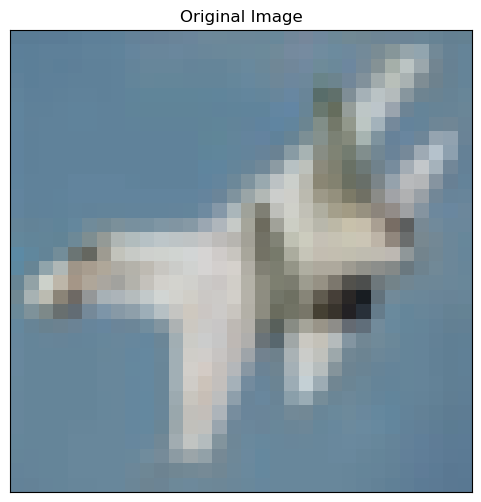

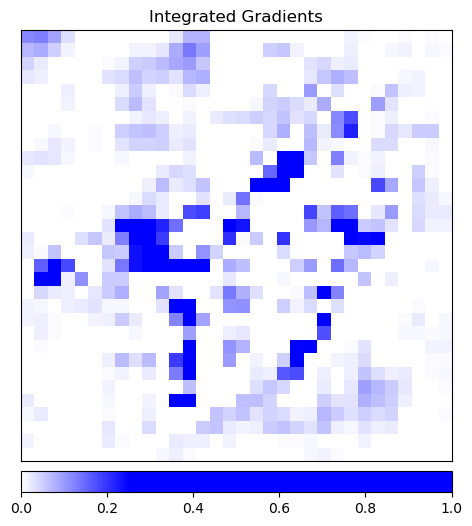

In [21]:
# Define Integrated Gradients 
ig = IntegratedGradients(model)

# Select Image to Demonstrate Saliency Map for
sample_idx = 10
sample_img = test_loader.dataset[sample_idx][0]
sample_img_label = test_loader.dataset[sample_idx][1]

unnormalize = transforms.Normalize((-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]),
                                   (1.0 / std[0], 1.0 / std[1], 1.0 / std[2]))
unnormalized_img = unnormalize(sample_img)

# Calculate attributions using Integrated Gradients
attributions = ig.attribute(sample_img.to(device).unsqueeze(0), target=sample_img_label, n_steps = 200)

# Visualize Saliency Map and Compare to Original Image
print(f"label is {sample_img_label} ({cifar_10_labels[sample_img_label]})")
_ = viz.visualize_image_attr(None, np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)
_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

### Use eps = 0.1

In [22]:
# Use Resnet 18 
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
model = model.to(device)

In [23]:
# Check Accuracy on Adversarial Images Only Before Adversarial Training 
model.eval()
correct = 0
total = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(model, images, labels, eps=0.1, alpha=0.5, iters=5)
    
    outputs = model(adv_images)
    predicted = torch.max(outputs, 1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on adversarial test set: {accuracy:.2f}%')

Accuracy on adversarial test set: 8.36%


In [24]:
# Adversarial Training
def train_model(model, num_epochs, enable_defense=True):
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
    ce_loss = nn.CrossEntropyLoss()
    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            if enable_defense:
                model.eval()   # Switch to eval mode while generating attack
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                adv_x_batch = pgd_attack(model, x_batch, y_batch, eps=0.1, alpha=0.5, iters=5)
                adv_x_batch = adv_x_batch.to(device)
                # include adv image for training
                model.train()
                out = model(adv_x_batch)
                batch_loss = ce_loss(out, y_batch)
                tot_steps += 1
                opt.zero_grad()
                batch_loss.backward()
                opt.step()
                # include original image for training
                model.train()
                out = model(x_batch)
                batch_loss = ce_loss(out, y_batch)
                tot_steps += 1
                opt.zero_grad()
                batch_loss.backward()
                opt.step()
                
        #Check Accuracy on Adversarial Images Only After Adversarial Training 
        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adv_x_batch = pgd_attack(model, x_batch, y_batch, eps=0.1, alpha=0.5, iters=5)
            adv_x_batch = adv_x_batch.to(device)
            out = model(adv_x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        print('Epoch %d: Accuracy on Adv Set Only%.5lf' % (epoch, tot_acc/tot_test))

In [25]:
train_model(model, 10, enable_defense=True)

Epoch 1: Accuracy on Adv Set Only0.27340
Epoch 2: Accuracy on Adv Set Only0.33870
Epoch 3: Accuracy on Adv Set Only0.35590
Epoch 4: Accuracy on Adv Set Only0.40690
Epoch 5: Accuracy on Adv Set Only0.43190
Epoch 6: Accuracy on Adv Set Only0.44200
Epoch 7: Accuracy on Adv Set Only0.44640
Epoch 8: Accuracy on Adv Set Only0.44800
Epoch 9: Accuracy on Adv Set Only0.47160
Epoch 10: Accuracy on Adv Set Only0.48680


label is 0 (airplane)


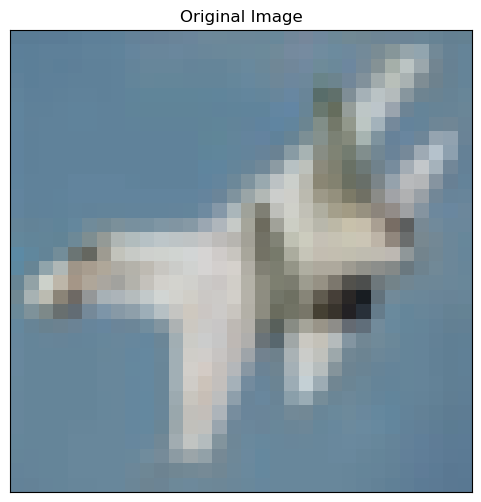

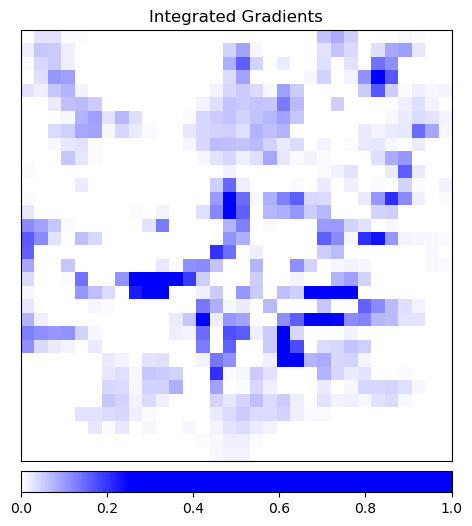

In [30]:
# Define Integrated Gradients 
ig = IntegratedGradients(model)

# Select Image to Demonstrate Saliency Map for
sample_idx = 10
sample_img = test_loader.dataset[sample_idx][0]
sample_img_label = test_loader.dataset[sample_idx][1]

unnormalize = transforms.Normalize((-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]),
                                   (1.0 / std[0], 1.0 / std[1], 1.0 / std[2]))
unnormalized_img = unnormalize(sample_img)

# Calculate attributions using Integrated Gradients
attributions = ig.attribute(sample_img.to(device).unsqueeze(0), target=sample_img_label, n_steps = 200)

# Visualize Saliency Map and Compare to Original Image
print(f"label is {sample_img_label} ({cifar_10_labels[sample_img_label]})")
_ = viz.visualize_image_attr(None, np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)
_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

### Use eps = 0.001

In [36]:
# Use Resnet 18 
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
model = model.to(device)

In [37]:
# Check Accuracy on Adversarial Images Only Before Adversarial Training 
model.eval()
correct = 0
total = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(model, images, labels, eps=0.001, alpha=0.5, iters=5)
    
    outputs = model(adv_images)
    predicted = torch.max(outputs, 1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on adversarial test set: {accuracy:.2f}%')

Accuracy on adversarial test set: 9.93%


In [38]:
# Adversarial Training
def train_model(model, num_epochs, enable_defense=True):
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
    ce_loss = nn.CrossEntropyLoss()
    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            if enable_defense:
                model.eval()   # Switch to eval mode while generating attack
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                adv_x_batch = pgd_attack(model, x_batch, y_batch, eps=0.001, alpha=0.5, iters=5)
                adv_x_batch = adv_x_batch.to(device)
                # include adv image for training
                model.train()
                out = model(adv_x_batch)
                batch_loss = ce_loss(out, y_batch)
                tot_steps += 1
                opt.zero_grad()
                batch_loss.backward()
                opt.step()
                # include original image for training
                model.train()
                out = model(x_batch)
                batch_loss = ce_loss(out, y_batch)
                tot_steps += 1
                opt.zero_grad()
                batch_loss.backward()
                opt.step()
                
        #Check Accuracy on Adversarial Images Only After Adversarial Training 
        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adv_x_batch = pgd_attack(model, x_batch, y_batch, eps=0.001, alpha=0.5, iters=5)
            adv_x_batch = adv_x_batch.to(device)
            out = model(adv_x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        print('Epoch %d: Accuracy on Adv Set Only%.5lf' % (epoch, tot_acc/tot_test))

In [39]:
train_model(model, 10, enable_defense=True)

Epoch 1: Accuracy on Adv Set Only0.40630
Epoch 2: Accuracy on Adv Set Only0.51530
Epoch 3: Accuracy on Adv Set Only0.55920
Epoch 4: Accuracy on Adv Set Only0.59420
Epoch 5: Accuracy on Adv Set Only0.59960
Epoch 6: Accuracy on Adv Set Only0.61630
Epoch 7: Accuracy on Adv Set Only0.63060
Epoch 8: Accuracy on Adv Set Only0.64310
Epoch 9: Accuracy on Adv Set Only0.63800
Epoch 10: Accuracy on Adv Set Only0.63610


label is 1 (automobile)


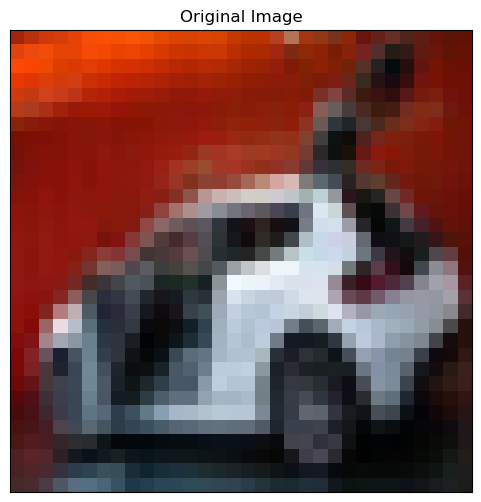

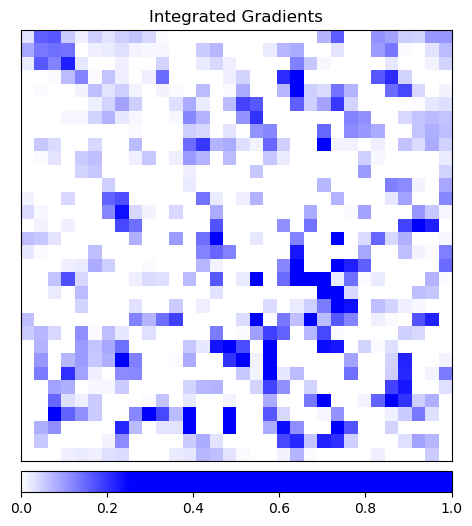

In [43]:
# Define Integrated Gradients 
ig = IntegratedGradients(model)

# Select Image to Demonstrate Saliency Map for
sample_idx = 6
sample_img = test_loader.dataset[sample_idx][0]
sample_img_label = test_loader.dataset[sample_idx][1]

unnormalize = transforms.Normalize((-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]),
                                   (1.0 / std[0], 1.0 / std[1], 1.0 / std[2]))
unnormalized_img = unnormalize(sample_img)

# Calculate attributions using Integrated Gradients
attributions = ig.attribute(sample_img.to(device).unsqueeze(0), target=sample_img_label, n_steps = 200)

# Visualize Saliency Map and Compare to Original Image
print(f"label is {sample_img_label} ({cifar_10_labels[sample_img_label]})")
_ = viz.visualize_image_attr(None, np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)
_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(unnormalized_img.cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')